# SMART
This file loads the trained category and type classifiers. The predicts and evaluate the results.

In [1]:
import utils
import pickle
import numpy as np
import gensim 
import json
from gensim.models import Word2Vec 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 
from elasticsearch import Elasticsearch

## Classify the category

In [2]:
clf_category = pickle.load(open('category_classifier.sav', 'rb'))

In [3]:
test = utils.load_dataset('datasets/DBpedia/test_grnd.json')

In [4]:
_, _, X_test, y_test = utils.prepare_X_y({}, test)
test_vectors = utils.transform_dataset(X_test, 'category_vectorizer.sav')

In [5]:
pred_category = clf_category.predict(test_vectors)
print("Accuracy:", sum(pred_category==y_test)/len(pred_category))

Accuracy: 0.9226380648105887


In [6]:
nBool = 0
nBoolWrong = 0
nLiteral = 0
nLiteralWrong = 0
nResource = 0
nResourceWrong = 0
for i in range(len(pred_category)):
    if pred_category[i] != y_test[i]:
        if y_test[i] == "boolean":
             nBoolWrong += 1
        elif y_test[i] == "literal":
            nLiteralWrong += 1
        elif y_test[i] == "resource":
            nResourceWrong += 1
    
    if y_test[i] == "boolean":
         nBool += 1
    elif y_test[i] == "literal":
         nLiteral += 1
    elif y_test[i] == "resource":
        nResource += 1

In [7]:
nCategories = [nBool, nLiteral, nResource]
nWrong = [nBoolWrong, nLiteralWrong, nResourceWrong]
nProp = [x/y for x, y in zip(nWrong, nCategories)]

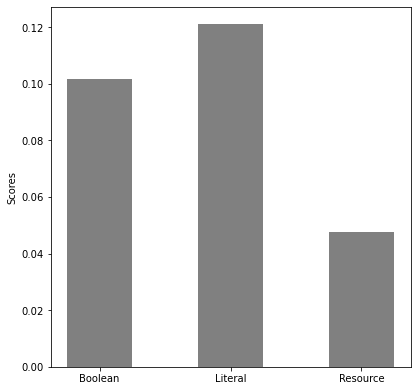

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = fig.add_axes([0,0,1,1])
labels = ['Boolean', 'Literal', 'Resource']
ax.bar(labels,nProp, color="grey", width=0.5)
ax.set_ylabel('Scores')
plt.show()

## Classify the type

In [9]:
clf_type_literal = pickle.load(open('type_literal_classifier.sav', 'rb'))

In [10]:
def split_bool_literal_reference(X, y):
    bool_map = {}
    literal_map = {}
    resource_map = {}

    for i in range(len(y)):
        if y[i] == 'boolean':
            bool_map[i] = X[i]
        elif y[i] == 'literal':
            literal_map[i] = X[i]
        elif y[i] == 'resource':
            resource_map[i] = X[i]
            
    return bool_map, literal_map, resource_map

In [11]:
bool_map, literal_map, resource_map = split_bool_literal_reference(X_test, pred_category)

In [12]:
X_test_literal = list(literal_map.values())
y_test_literal = []
for i in list(literal_map.keys()):
    y_test_literal.append(test[i]['type'][0])

In [13]:
test_vectors_literal = utils.transform_dataset(X_test_literal, 'literal_vectorizer.sav')

In [14]:
pred_literal = clf_type_literal.predict(test_vectors_literal)
print("Accuracy:", sum(pred_literal==y_test_literal)/len(pred_literal))

Accuracy: 0.8787128712871287


## Bundle

In [15]:
es = Elasticsearch()
INDEX_NAME = 'questions'
es.info()

{'name': 'DESKTOP-JA1LK0U',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'PBepFijXTgGNWra55N7P7g',
 'version': {'number': '7.9.1',
  'build_flavor': 'default',
  'build_type': 'zip',
  'build_hash': '083627f112ba94dffc1232e8b42b73492789ef91',
  'build_date': '2020-09-01T21:22:21.964974Z',
  'build_snapshot': False,
  'lucene_version': '8.6.2',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

In [16]:
q = 'Is cola healthy?'

es.search(index=INDEX_NAME, q=q, _source=True, size=2).get('hits', {}).get('hits', {})

[{'_index': 'questions',
  '_type': '_doc',
  '_id': 'dbpedia_16642',
  '_score': 9.011995,
  '_source': {'question': 'Who manufactures Coca-Cola?',
   'category': 'resource',
   'type': ['dbo:Company', 'dbo:Organisation', 'dbo:Agent']}},
 {'_index': 'questions',
  '_type': '_doc',
  '_id': 'dbpedia_3697',
  '_score': 7.914068,
  '_source': {'question': 'What products does Coca-Cola produce?',
   'category': 'resource',
   'type': ['dbo:Company', 'dbo:Organisation', 'dbo:Agent']}}]

In [17]:
stop_words = set(stopwords.words('english'))
word2vec_sg = pickle.load(open('word2vec_sg.sav', 'rb'))
word2vec_sg.wv.most_similar('church') # Check if working

[('Conqueror', 0.9905463457107544),
 ('Hotel', 0.9893677830696106),
 ('patron', 0.9886565804481506),
 ('line', 0.9868284463882446),
 ('ground', 0.9866505265235901),
 ('airport', 0.9864086508750916),
 ('architect', 0.9858438372612),
 ('saint', 0.9854694604873657),
 ('Tokyo', 0.9853686094284058),
 ('begins', 0.9853509664535522)]

In [18]:
def predict_resource_types(es, testdata, index, model, index_name='questions', size=5):
    q = testdata[index]['question']
    q = " ".join([w for w in word_tokenize(q)  if not w in stop_words])
    results = []
    try:
        results = es.search(index=index_name, q=q, _source=True, size=size).get('hits', {}).get('hits', {})
    except:
        return []
    types = set([])
    for result in results:
        for t in result['_source']['type']:
            if len(t.split()) == 1:
                types.add(t)

    q_terms = q.split() # Question terms
    t_terms = list(types) # Types from search
    pred_types = set([])
     
    return predictTypes(model, q_terms, t_terms)

#     for i in q_terms:
#         for j in t_terms:
#             try:
#                 score = model.wv.similarity(i, j[4:])
#                 if score > threshold:
#                     pred_types.add(j)
#     #                 print(i, j, score)
#             except:
#                 pass

#     return list(pred_types)

In [19]:
def predictTypes(model, q_terms, t_terms, nTerms=5):
    threshold = 1.0
    pred_types = set([])
    while len(pred_types) < nTerms:
        for i in q_terms:
            for j in t_terms:
                try:
                    score = model.wv.similarity(i, j[4:])
                    if score > threshold:
                        pred_types.add(j)
                except:
                    pass
        threshold -= 0.05
        if threshold < 0.6:
            break
#     if len(pred_types) > 5:
#         return list(pred_types)[0:6]
    return list(pred_types)

In [20]:
predict_resource_types(es, test, 1431, word2vec_sg)

['dbo:Album', 'dbo:MusicalWork', 'dbo:Award', 'dbo:Work']

In [22]:
type_preds = []
count_literal = 0
for i in range(len(test)):
    
    if i in bool_map:
        type_preds.append(['boolean'])
    if i in literal_map:
        type_preds.append([pred_literal[count_literal]])
        count_literal += 1
    if i in resource_map:
        type_preds.append(predict_resource_types(es, test, i, word2vec_sg))

In [23]:
type_preds[0:5]

[['number'],
 ['dbo:Company',
  'dbo:Single',
  'dbo:MusicalWork',
  'dbo:Work',
  'dbo:RecordLabel'],
 ['number'],
 ['boolean'],
 ['string']]

In [25]:
predict_resource_types(es, test, 1, word2vec_sg)

['dbo:Company', 'dbo:Single', 'dbo:MusicalWork', 'dbo:Work', 'dbo:RecordLabel']

In [26]:
y_test_types = []
    
for doc in test:
    y_test_types.append(doc['type'])

In [27]:
preds = utils.load_dataset('datasets/DBpedia/test.json')
for i, doc in enumerate(preds):
    
    if i in bool_map:
        doc['category'] = 'boolean'
    if i in literal_map:
        doc['category'] = 'literal'
    if i in resource_map:
        doc['category'] = 'resource'
    doc['type'] = type_preds[i]

with open('datasets/DBpedia/preds.json', 'w') as file:
    json.dump(preds, file, indent=4)

In [ ]:
# score = 0
# bool_score = 0
# literal_score = 0
# resource_score_penalty = 0
# resource_score_no_penalty = 0
# resource_score_min_1_correct = 0
# for i in range(len(test)):
#     if i in bool_map:
#         score += type_preds[i] == y_test_types[i][0]
#         bool_score += type_preds[i] == y_test_types[i][0]
#     if i in literal_map:
#         score += type_preds[i] == y_test_types[i][0]
#         literal_score += type_preds[i] == y_test_types[i][0]
#     if i in resource_map:
#         preds = type_preds[i]
#         labels = y_test_types[i]
#         sub_score = 0
#         penalty = 0
#         min_1_correct = False
#         for pred in preds:
#             if pred in labels:
#                 sub_score += 1/len(labels)
#                 min_1_correct = True
#             else:
#                 penalty += 1/len(labels)
                
#         resource_score_no_penalty += sub_score
#         resource_score_penalty += max(sub_score - penalty, 0)
#         if min_1_correct:
#             resource_score_min_1_correct += 1
#         score += max(sub_score, 0)
        
        
# # print(score / len(y_test_types))
# print("Individual category accuracy on their respective category subsets")
# print("Boolean accuracy:", bool_score/ len(bool_map))
# print("Literal accuracy:", literal_score/ len(literal_map))
# print("Resource min 1 correct accuracy:", resource_score_min_1_correct/ len(resource_map))
# print("Resource no penalty accuracy:", resource_score_no_penalty/ len(resource_map))
# print("Resource penalty accuracy:", resource_score_penalty/ len(resource_map))
# print()
# print("Individual category accuracy on across entire test set")
# print("Boolean accuracy:", bool_score/ len(y_test_types))
# print("Literal accuracy:", literal_score/ len(y_test_types))
# print("Resource min 1 correct accuracy:", resource_score_min_1_correct/ len(y_test_types))
# print("Resource no penalty accuracy:", resource_score_no_penalty/ len(y_test_types))
# print("Resource penalty accuracy:", resource_score_penalty/ len(y_test_types))
# print()
# print("Total score")
# print("Resource min 1 correct accuracy:", (resource_score_min_1_correct + bool_score + literal_score)/ len(y_test_types))
# print("Resource no penalty accuracy:", (resource_score_no_penalty + bool_score + literal_score)/ len(y_test_types))
# print("Resource penalty accuracy:", (resource_score_penalty + bool_score + literal_score)/ len(y_test_types))

Decisions made:

* We used MLP for category classification because there are a known amount of labels (multi class classification)
* Boolean category is always boolean type, so no need for further classification/ prediction
* We used MLP for literal type classifications because there are a known amount of labels (multi class classification)
* We use CountVectorizer because TFIDF penalize frequent words (who, what ...)
* We use pickle to serialize MLP models and vectorizers
* For resource, we start by looking for similar questions using elasticsearch (bm25)
* Use skip-gram word2vec embedding to cross-reference types found in search and terms in query
* Skip-gram predict the context better than CBOW (CBOW often have meaningless predictions)
* Mention that we ignore types that are more than one word due to limitations in word2vec
* Boolean and literal types have a strict scoring (0 or 1)
* Have not decided how to score resource types (+/- proportion of terms)

TODO:
* Optimize MLP models
* Improve implementation of resource scoring
* Extend the indexed text by concatenating description of the types
* Type hierarchy
* Try dbpedia

* How we concatenate question and types in word2vec have a major impact on performance
